In [42]:
import pandas as pd

In [43]:
TRACK_COUNT_DATA_PATH = "/Users/user/data/research/proton-deuteron/bruno/root/output.csv"
PROTON_PRESELECTION = "/Users/user/data/research/proton-deuteron/csv/preprotons_pm_600_1600.csv"
RAW_FILES = "/Users/user/data/research/proton-deuteron/rawprotons/renamed"

In [32]:
trackdf = pd.read_csv(TRACK_COUNT_DATA_PATH)
protondf = pd.read_csv(PROTON_PRESELECTION)

In [34]:
trackdf, trackdf.columns

(         run  subrun  event  ntracks_reco
 0       8675      12   1249             1
 1       8675      12   1250            23
 2       8675      12   1256             2
 3       8675      12   1257             2
 4       8675      12   1258             3
 ...      ...     ...    ...           ...
 580633  9781     133  21593             0
 580634  9781     133  21596             2
 580635  9781     133  21614             4
 580636  9781     133  21621             2
 580637  9781     133  21623             7
 
 [580638 rows x 4 columns],
 Index(['run', 'subrun', 'event', 'ntracks_reco'], dtype='object'))

In [35]:
protondf, protondf.columns

(        run  subrun  event
 0      8675      38   4220
 1      8675      40   4514
 2      8675      54   5807
 3      8675      54   5821
 4      8675      54   5843
 ...     ...     ...    ...
 16930  9781     109  17974
 16931  9781     111  18262
 16932  9781     112  18441
 16933  9781     124  20209
 16934  9781     127  20677
 
 [16935 rows x 3 columns],
 Index(['run', 'subrun', 'event'], dtype='object'))

In [36]:
protontrackdf = trackdf.merge(
    protondf[['run', 'subrun', 'event']],
    on=['run', 'subrun', 'event'],
    how='inner'
)

In [37]:
protontrackdf

,run,subrun,event,ntracks_reco
0,8675,38,4220,2
1,8675,40,4514,6
2,8675,54,5807,1
3,8675,54,5821,1
4,8675,54,5843,2
...,...,...,...,...
16930,9781,109,17974,1
16931,9781,111,18262,2
16932,9781,112,18441,1
16933,9781,124,20209,1


In [38]:
onetrackdf = protontrackdf[(protontrackdf['ntracks_reco'] == 1)]

In [39]:
onetrackdf

,run,subrun,event,ntracks_reco
2,8675,54,5807,1
3,8675,54,5821,1
5,8675,54,5844,1
8,8675,68,7061,1
10,8675,88,9222,1
...,...,...,...,...
16927,9781,103,16997,1
16928,9781,109,17945,1
16930,9781,109,17974,1
16932,9781,112,18441,1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import awkward as ak
from pathlib import Path

class EventSearchViewer():
    """
    Event viewer that searches through ROOT files by opening them
    and checking the ana/raw tree for matching events, with beamline mass info
    """
    def __init__(self, onetrackdf, root_files_dir):
        self.onetrackdf = onetrackdf
        self.root_files_dir = Path(root_files_dir)
        self.matched_events = self._search_matching_events()
        
    def _search_matching_events(self):
        """Search all ROOT files for events that match onetrackdf"""
        print("Searching ROOT files for matching events...")
        matched = []
        
        # Get target events from onetrackdf
        target_events = set()
        for idx, row in self.onetrackdf.iterrows():
            run = int(row['run'])
            subrun = int(row['subrun'])
            event = int(row['event'])
            target_events.add((run, subrun, event))
        
        # Search through all ROOT files
        root_files = list(self.root_files_dir.glob("*.root"))
        print(f"Found {len(root_files)} ROOT files to search")
        
        for i, root_file in enumerate(root_files):
            if i % 10 == 0:
                print(f"Searching file {i+1}/{len(root_files)}: {root_file.name}")
            
            try:
                with uproot.open(root_file) as file:                # Check if ana/raw tree exists
                if "ana/raw" not in file:
                    continue
                
                tree = file["ana/raw"]
                
                # Get all events in this file
                try:
                    events_data = tree.arrays(["run", "subrun", "event"], library="pd")
                    
                    # Check each event in this file
                    for event_idx, event_row in events_data.iterrows():
                        run = int(event_row['run'])
                        subrun = int(event_row['subrun'])
                        event = int(event_row['event'])
                        
                        # Check if this event is in our target list
                        if (run, subrun, event) in target_events:
                            # Try to get beamline mass information
                            beamline_mass = None
                            try:
                                # Check if there's a beamline tree or mass info in the same tree
                                if "beamlinemass" in tree.keys():
                                    mass_data = tree.arrays(["beamlinemass"], library="pd", 
                                                          entry_start=event_idx, entry_stop=event_idx+1)
                                    if not mass_data.empty:
                                        beamline_mass = float(mass_data.iloc[0]['beamlinemass'])
                                elif "mass" in tree.keys():
                                    mass_data = tree.arrays(["mass"], library="pd", 
                                                          entry_start=event_idx, entry_stop=event_idx+1)
                                    if not mass_data.empty:
                                        beamline_mass = float(mass_data.iloc[0]['mass'])
                                # Check other possible trees
                                elif "ana/beamline" in file:
                                    beam_tree = file["ana/beamline"]
                                    if "mass" in beam_tree.keys():
                                        mass_data = beam_tree.arrays(["mass"], library="pd",
                                                                   entry_start=event_idx, entry_stop=event_idx+1)
                                        if not mass_data.empty:
                                            beamline_mass = float(mass_data.iloc[0]['mass'])
                            except Exception as mass_error:
                                print(f"  Warning: Could not read beamline mass: {mass_error}")
                            
                            matched.append({
                                'run': run,
                                'subrun': subrun,
                                'event': event,
                                'file_path': str(root_file),
                                'filename': root_file.name,
                                'event_index_in_file': event_idx,
                                'beamline_mass': beamline_mass
                            })
                            mass_str = f", Mass: {beamline_mass:.3f}" if beamline_mass is not None else ", Mass: N/A"
                            print(f"  ✓ Found match: Run {run}, Subrun {subrun}, Event {event}{mass_str}")
                
                except Exception as e:
                    print(f"  Error reading events from {root_file.name}: {e}")
                    continue
                        
            except Exception as e:
                print(f"  Error opening {root_file.name}: {e}")
                continue
        
        print(f"\nSearch complete! Found {len(matched)} matching events")
        return matched
    
    def show_event(self, match_index=0):
        """Show collection plane for specific matched event"""
        if match_index >= len(self.matched_events):
            print(f"Match index {match_index} out of range (max: {len(self.matched_events)-1})")
            return
            
        event_info = self.matched_events[match_index]
        
        try:
            # Load ROOT file
            with uproot.open(event_info['file_path']) as root_file:
                tree = root_file["ana/raw"]
                
                # Get data for the specific event
                branches_to_load = ["run", "subrun", "event", "raw_rawadc", "raw_channel"]
                
                # Load specific event by index
                event_start = event_info['event_index_in_file']
                event_data = tree.arrays(branches_to_load, library="pd", 
                                       entry_start=event_start, entry_stop=event_start+1)
                
                if event_data.empty:
                    print("No data found for this event")
                
                # Include beamline mass in title if available
                mass_str = f", Mass: {event_info['beamline_mass']:.3f}" if event_info['beamline_mass'] is not None else ""
                title = f"Collection Plane - Run {event_info['run']}, Subrun {event_info['subrun']}, Event {event_info['event']}{mass_str}"
                plt.title(title)
                plt.show()
                
                # Print event info including mass
                mass_info = f", Beamline Mass: {event_info['beamline_mass']:.3f}" if event_info['beamline_mass'] is not None else ", Beamline Mass: N/A"
                print(f"Showing match {match_index}/{len(self.matched_events)-1} from file: {event_info['filename']}{mass_info}")
                
        except Exception as e:
            print(f"Error loading event: {e}")
    
    def show_next_events(self, start_index=0, num_events=3):
        """Show multiple events in sequence"""
        """List all matched events with beamline mass information"""
            print(f"\n--- Event {i} ---")
            self.show_event(i)
            mass_str = f", Mass: {event['beamline_mass']:.3f}" if event['beamline_mass'] is not None else ", Mass: N/A"
            print(f"{i}: Run {event['run']}, Subrun {event['subrun']}, Event {event['event']}{mass_str} (from {event['filename']})")
        print(f"\nTotal: {len(self.matched_events)} matches")
    
    def get_mass_statistics(self):
        """Get statistics about beamline masses"""
        masses = [evt['beamline_mass'] for evt in self.matched_events if evt['beamline_mass'] is not None]
        
        if masses:
            print(f"\nBeamline Mass Statistics:")
            print(f"  Events with mass data: {len(masses)}/{len(self.matched_events)}")
            print(f"  Mean mass: {np.mean(masses):.3f}")
            print(f"  Std mass: {np.std(masses):.3f}")
            print(f"  Min mass: {np.min(masses):.3f}")
            print(f"  Max mass: {np.max(masses):.3f}")
        for i in range(start_index, min(start_index + num_events, len(self.matched_events))):
            print(f"\n--- Event {i} ---")
            self.show_event(i)
    
    def list_matches(self):
        """List all matched events"""
        print("Matched events found:")
        for i, event in enumerate(self.matched_events):
            print(f"{i}: Run {event['run']}, Subrun {event['subrun']}, Event {event['event']} (from {event['filename']})")
        print(f"\nTotal: {len(self.matched_events)} matches")

# Usage:
# 1. Create viewer (this will search all ROOT files - may take a while)
viewer = EventSearchViewer(onetrackdf, "/Users/user/data/research/proton-deuteron/rawprotons/renamed")

# 2. List all matches
# viewer.list_matches()

# 3. Show specific events
# viewer.show_event(0)  # Show first match
# viewer.show_event(5)  # Show match at index 5

# 4. Show multiple events
# viewer.show_next_events(0, 3)  # Show first 3 matches

Searching ROOT files for matching events...
Found 12530 ROOT files to search
Searching file 1/12530: 9511_121_10751.root
  ✓ Found match: Run 9551, Subrun 87, Event 5508
  ✓ Found match: Run 9493, Subrun 62, Event 4829
  ✓ Found match: Run 8740, Subrun 271, Event 26850
  ✓ Found match: Run 8681, Subrun 423, Event 34500
  ✓ Found match: Run 9550, Subrun 12, Event 952
Searching file 11/12530: 9486_18_1599.root
  ✓ Found match: Run 9486, Subrun 18, Event 1599
  ✓ Found match: Run 9488, Subrun 254, Event 20149
  ✓ Found match: Run 8758, Subrun 37, Event 3530
  ✓ Found match: Run 8740, Subrun 407, Event 40940
  ✓ Found match: Run 8561, Subrun 47, Event 1440
  ✓ Found match: Run 8686, Subrun 270, Event 28039
Searching file 21/12530: 8652_309_24080.root
  ✓ Found match: Run 9514, Subrun 89, Event 7631
Searching file 31/12530: 8630_136_9221.root
  ✓ Found match: Run 8596, Subrun 193, Event 17931
  ✓ Found match: Run 8667, Subrun 312, Event 26098
  ✓ Found match: Run 8667, Subrun 312, Event 261

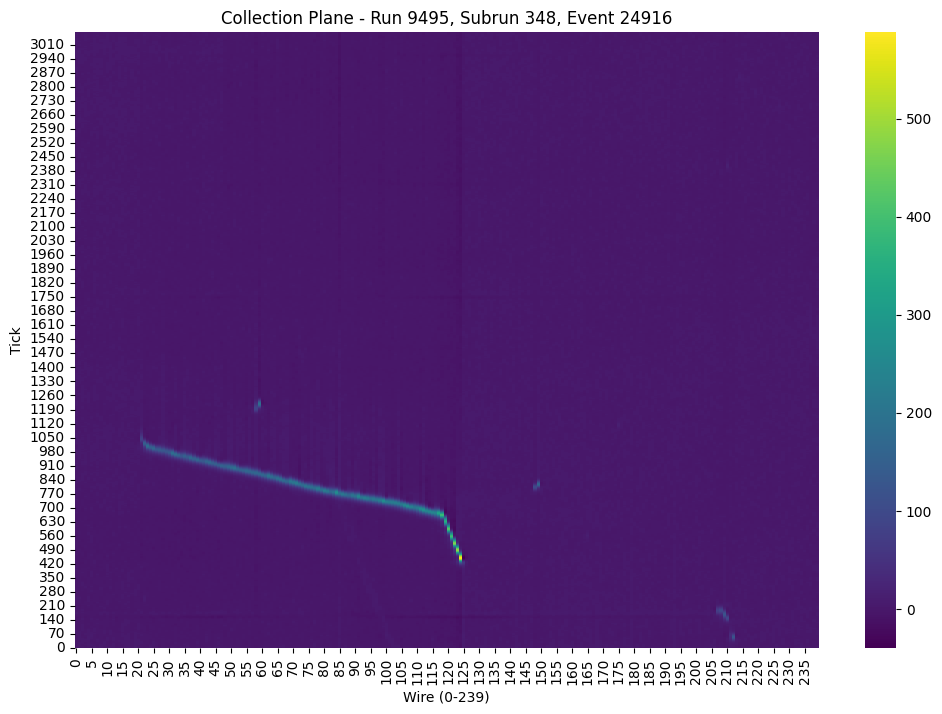

Showing match 33/7635 from file: 9495_348_24916.root


In [171]:
viewer.show_event(33)